# Extra Credits (EC) 
due 04/03/2019 

### Option (1) 

Extend HW 5 with the following:  
- a. Show the page titles in the results (join with index file)  
- b. Implement using both RDDs and DataFrames. Is this possible? What are the tradeoffs?
- c. Run our 2GB wiki dataset through pragerank in graphframes and compare/contrast your implementation with GraphFrames. 
- d. Implement Topic Specific PageRank

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
import re
import ast
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [4]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "ec_notebook"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

__`REMINDER`__: If you are running this notebook on the course docker container, you can monitor the progress of your jobs using the Spark UI at: http://localhost:4040/jobs/

In [5]:
# Since we already downloaded data from HW5, we just imported into Spark RDD. 

testRDD = sc.textFile('data/test_graph.txt')
indexRDD = sc.textFile('data/indices.txt')
wikiRDD = sc.textFile('data/wiki_graph.txt')

In [47]:
# part b - count the number of records in the raw data (RUN THIS CELL AS IS)
!wc -l data/wiki_graph.txt

 5781290 data/wiki_graph.txt


In [48]:
!head data/wiki_graph.txt

73	{'14417532': 1}
299	{'4214575': 1}
2552	{'15043376': 1, '13430968': 1, '13451035': 1, '7263397': 1, '13001625': 1, '13443575': 1, '13451269': 1, '13432316': 1, '11623371': 1, '15028971': 1, '13425865': 1, '15042703': 1, '5051368': 1, '9854998': 2, '13442976': 1, '13315025': 1, '2992307': 1, '1054486': 1, '1322325': 1, '13450983': 1}
2570	{'983991': 1}
2616	{'9045350': 1}
2711	{'752887': 1}
2818	{'3534183': 1}
2847	{'3797918': 1}
2892	{'2893': 1}
2921	{'5158607': 1, '6007184': 1, '14773825': 1, '11777840': 2, '9285165': 1, '6420484': 1, '14670682': 1, '7316613': 1, '7125893': 1, '14965920': 1, '14229952': 1, '9447742': 2, '1425342': 1, '11390944': 2, '5141': 1, '14928135': 2, '13636570': 3, '14687433': 1, '15105458': 1, '11656072': 1, '6420027': 1, '10898196': 1, '6416278': 1, '11497740': 2}


In [18]:
# part c - write your Spark job here (compute total number of nodes)
def count_nodes(dataRDD):
    """
    Spark job to count the total number of nodes.
    Returns: integer count 
    """    
    ############## YOUR CODE HERE ###############
 
    def countNodes(pair):
        key, value = pair
        yield (key)
        for node in ast.literal_eval(value).keys():
            yield (node)
       
    totalCount = dataRDD.map(lambda line: line.split('\t')) \
                        .flatMap(countNodes) \
                        .distinct() \
                        .count()
    
    ############## (END) YOUR CODE ###############   
    return totalCount

In [16]:
# part c - run your counting job on the full file (RUN THIS CELL AS IS)
start = time.time()
tot = count_nodes(wikiRDD)
print(f'... completed job in {time.time() - start} seconds.')
print('Total Nodes:', tot)

... completed job in 756.5067429542542 seconds.
Total Nodes: 15192277


In [6]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraph(dataRDD):
    """
    Spark job to read in the raw data and initialize an 
    adjacency list representation with a record for each
    node (including dangling nodes).
    
    Returns: 
        graphRDD -  a pair RDD of (node_id , (score, edges))
        
    NOTE: The score should be a float, but you may want to be 
    strategic about how format the edges... there are a few 
    options that can work. Make sure that whatever you choose
    is sufficient for Question 8 where you'll run PageRank.
    """
    ############## YOUR CODE HERE ###############

    # write any helper functions here
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    def adjList(pair):
        node, edges = pair
        for edge in edges.keys():
            yield (node, [edge])
            yield (edge, [])          # This emitting avoids accidentally missing dangling nodes 
    
    # write your main Spark code here
    
    tempRDD = dataRDD.map(parse) \
                    .flatMap(adjList) \
                    .reduceByKey(lambda x, y : x+y) \
                    .cache()
    
    N = tempRDD.count()
    
    graphRDD = tempRDD.map(lambda x: (x[0], (1/N, x[1])))
     
    ############## (END) YOUR CODE ##############
    
    return graphRDD

In [51]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
wikiGraphRDD = initGraph(wikiRDD)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 1237.2869539260864 seconds


In [7]:
# part d - provided FloatAccumulator class (RUN THIS CELL AS IS)

from pyspark.accumulators import AccumulatorParam

class FloatAccumulatorParam(AccumulatorParam):
    """
    Custom accumulator for use in page rank to keep track of various masses.
    
    IMPORTANT: accumulators should only be called inside actions to avoid duplication.
    We stringly recommend you use the 'foreach' action in your implementation below.
    """
    def zero(self, value):
        return value
    def addInPlace(self, val1, val2):
        return val1 + val2

In [8]:
# part d - job to run PageRank (RUN THIS CELL AS IS)
def runPageRank(graphInitRDD, alpha = 0.15, maxIter = 10, verbose = True):
    """
    Spark job to implement page rank
    Args: 
        graphInitRDD  - pair RDD of (node_id , (score, edges))
        alpha         - (float) teleportation factor
        maxIter       - (int) stopping criteria (number of iterations)
        verbose       - (bool) option to print logging info after each iteration
    Returns:
        steadyStateRDD - pair RDD of (node_id, pageRank)
    """
    # teleportation:
    a = sc.broadcast(alpha)
    
    # damping factor:
    d = sc.broadcast(1-a.value)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0)
    totAccum = sc.accumulator(0.0)
    
    ############## YOUR CODE HERE ###############
    
    # write your helper functions here, 
    # please document the purpose of each clearly 
    # for reference, the master solution has 5 helper functions.
    
    def calc_missing_mass (graph):
        """accumulate all dangling node mass or missing mass"""
        node, (mass, neighbors) = graph
        if neighbors == []:
            mmAccum.add(float(mass))
        
    def dist_prob (graph):
        """redistribution probability mass"""
        node, (mass, neighbors) = graph
        N = len(neighbors)                           # number of reachable nodes (hyperlinked webpages)

        if N == 0:
            yield (node, (0, []))                    # no linked webpages 
        elif N > 0:
            proba_mass = mass/N                      # probability mass for each of the linked webpages
            for neighbor in neighbors:
                yield(neighbor, (proba_mass, []))
            yield (node, (0, neighbors))
      
    def combine_mass (graph):
        """combining all probability mass"""
        node, (mass, neighbors) = graph
        dist_missing_mass = missing_mass/G
        
        yield (node, (a.value * (1/G) + d.value * (dist_missing_mass + mass), neighbors))
    
    def total_mass (graph):
        """combining all mass from all nodes, should equal to 1."""
        node, (mass, neighbors) = graph
        totAccum.add(float(mass))
        
    # write your main Spark Job here (including the for loop to iterate)
    # for reference, the master solution is 21 lines including comments & whitespace
    
    G = graphInitRDD.count()             # total number of nodes or webpages in the graph
    tempRDD1 = graphInitRDD
    
    # Since we're using the iteration rather than convergence, it's going to be for-loop format
    for i in range(maxIter):
        
        #step1: accumulate dangling mass
        tempRDD1.foreach(calc_missing_mass)
        missing_mass = mmAccum.value
        if verbose:
            print("Dangling mass: ", mmAccum)
        mmAccum = sc.accumulator(0.0)            # resetting to 0.0 for next loop value
        
        #step 2: redistribute mass and combine mass for nodes
        tempRDD2 = tempRDD1.flatMap(dist_prob) \
                            .reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1])) \
                            .flatMap(combine_mass) \
                            .cache()
    
        tempRDD2.foreach(total_mass)
        if verbose:
            print("Total mass   : ", totAccum)
        totAccum = sc.accumulator(0.0)           # resetting to 0.0 for next loop value
        
        tempRDD1 = tempRDD2                      # keep variable name consistent for next loop
    
    steadyStateRDD = tempRDD1.map(lambda x: (x[0], x[1][0]))
    
    ############## (END) YOUR CODE ###############
    
    return steadyStateRDD

# A. Show the page titles in the results (join with index file)

In [13]:
# Loading index and caching them

def parse(line):
    title, index, val1, val2 = line.split('\t')
    return (index, title)    

titles = indexRDD.map(parse) \
                    .cache()

# Running pagerank on wikigraph with 10 iterations
# join the output with the index, inner join with 'index' as a common 
# take the top 20 

nIter = 10
start = time.time()
full_results = runPageRank(wikiGraphRDD, alpha = 0.15, maxIter = nIter, verbose = True)
 
topTitles = full_results.join(titles) \
                        .map(lambda x: [x[1][1], x[0], x[1][0]] ) \
                        .takeOrdered(30, key=lambda x: -x[2])
                                        
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print("-"*50)
print(f'\nTop 30 ranked Webpages based on PageRank\n')
topTitles

Dangling mass:  0.6194586236167866
Total mass   :  1.0000000000011389
Dangling mass:  0.5008445418004744
Total mass   :  1.0000000000013671
Dangling mass:  0.46754257467316024
Total mass   :  1.0000000000017268
Dangling mass:  0.45686319074265297
Total mass   :  1.0000000000004465
Dangling mass:  0.4531618613289884
Total mass   :  1.000000000001258
Dangling mass:  0.4517543987425795
Total mass   :  1.0000000000003693
Dangling mass:  0.45118542026463493
Total mass   :  0.9999999999997026
Dangling mass:  0.4509418903188725
Total mass   :  1.0000000000003635
Dangling mass:  0.4508326438188405
Total mass   :  1.0000000000002356
Dangling mass:  0.45078130691544266
Total mass   :  0.9999999999999399
...trained 10 iterations in 2757.1093640327454 seconds.
--------------------------------------------------

Top 30 ranked Webpages based on PageRank



[['United States', '13455888', 0.0014614491944282561],
 ['Animal', '1184351', 0.0006663317376702772],
 ['France', '4695850', 0.000639805187632495],
 ['Germany', '5051368', 0.0005748538827020078],
 ['Arthropod', '1384888', 0.00045030471434020375],
 ['Canada', '2437837', 0.00044660099104517264],
 ['Insect', '6113490', 0.0004448182480774587],
 ['List of sovereign states', '7902219', 0.0004442037346548337],
 ['United Kingdom', '13425865', 0.0004329952449795574],
 ['India', '6076759', 0.0004278853361862435],
 ['England', '4196067', 0.0004232759549601794],
 ['Iran', '6172466', 0.0003981702959211877],
 ['World War II', '14112583', 0.00038543367085653164],
 ['Poland', '10390714', 0.0003631670660923153],
 ['village', '15164193', 0.0003438311076771972],
 ['Countries of the world', '3191491', 0.00033834786526424363],
 ['Japan', '6416278', 0.00032935246270001544],
 ['Italy', '6237129', 0.000328969965605692],
 ['List of countries', '7835160', 0.0003263207199080851],
 ['Australia', '1516699', 0.0003

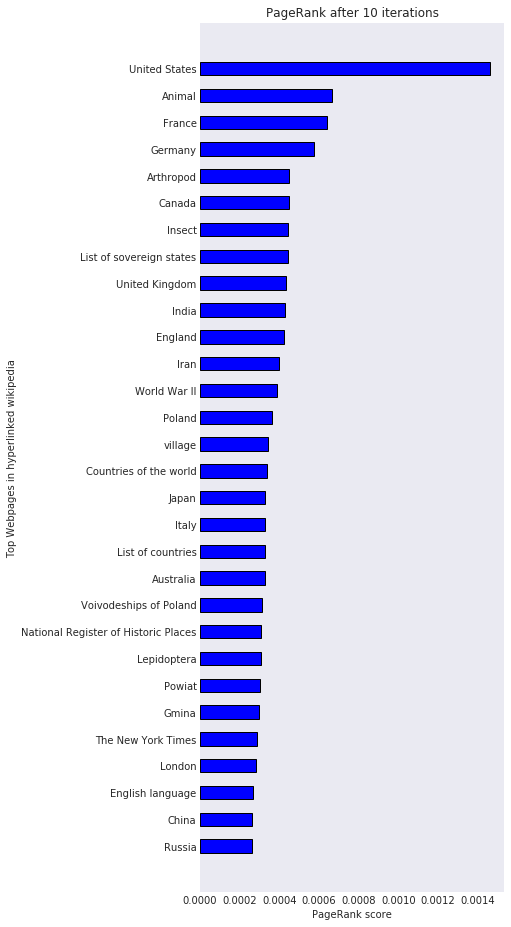

In [14]:
# Printing the top rank webpages in graph 

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

top30array = np.array(topTitles)
top30names = top30array[:, 0]
top30pagerank = top30array[:, 2].astype('float')

def plotPageRanks(rows, cols, idx, y, x, title):
    ax = plt.subplot(rows, cols, idx)
    ax.barh(y, x, height=0.5, tick_label=top30names, color='blue', edgecolor='black')
    ax.spines['left'].set_visible(True)
    ax.get_yaxis().tick_left()
    plt.title(title)
    plt.xlabel('PageRank score')
    plt.ylabel('Top Webpages in hyperlinked wikipedia')
    
y = list(range(30))         # converting to list since Python3 returns object in range, whereas python2 automatically returns a list in range
y.reverse()

plt.figure(figsize=(12, 16))
plotPageRanks(1, 2, 1, y, top30pagerank, 'PageRank after 10 iterations')

# B. Implement using both RDDs and DataFrames. Is this possible? What are the tradeoffs?


In [15]:
# Creating DataFrame on the raw wikiGraphRDD
# Just a plain transformation without defining the columns 

wikiDF = spark.createDataFrame(wikiGraphRDD)

In [12]:
wikiDF.show()

+--------+--------------------+
|      _1|                  _2|
+--------+--------------------+
|11777840|[6.58229177890845...|
|    3306|[6.58229177890845...|
|  677882|[6.58229177890845...|
| 4378841|[6.58229177890845...|
| 8986617|[6.58229177890845...|
|11360324|[6.58229177890845...|
| 6786010|[6.58229177890845...|
|   12472|[6.58229177890845...|
| 5964116|[6.58229177890845...|
|   16182|[6.58229177890845...|
| 9972558|[6.58229177890845...|
| 8148955|[6.58229177890845...|
| 8175275|[6.58229177890845...|
| 4585011|[6.58229177890845...|
|10065641|[6.58229177890845...|
| 6884354|[6.58229177890845...|
|12789437|[6.58229177890845...|
| 9443071|[6.58229177890845...|
| 9401906|[6.58229177890845...|
|   21439|[6.58229177890845...|
+--------+--------------------+
only showing top 20 rows



In [17]:
# Create DataFrame on the output from the wikiGraph and Indices 

full_resultsDF = spark.createDataFrame(full_results).toDF("Index", "PageRank")
titlesDF = spark.createDataFrame(titles).toDF("Index", "Title")

In [18]:
full_resultsDF.show()
titlesDF.show()

+--------+--------------------+
|   Index|            PageRank|
+--------+--------------------+
|14765621|7.275210235972736E-6|
|11777840|8.140956028959344E-8|
|    3306|3.677808622670605...|
|  677882|5.031884267205474...|
| 4378841|1.666599789261562...|
| 8986617|1.829416714352075...|
|11360324|1.123819284727364...|
| 3942258|6.576873267268602E-7|
| 6786010|3.656328204726229E-8|
|   12472|7.482664167991034E-8|
| 5964116|3.017498478954642E-7|
|  826261|1.299446812810989...|
|10527303|1.776064608121713...|
| 9972558|1.217129597091989...|
|   16182|1.383093167162913E-7|
| 8148955|1.751351082890686E-6|
| 8175275|5.287947354877229E-6|
| 6801676|6.033144088457158E-8|
| 4220534|7.507936378955555E-8|
| 5479923|1.668541065382351...|
+--------+--------------------+
only showing top 20 rows

+-----+--------------------+
|Index|               Title|
+-----+--------------------+
|    1|! $var = &quot;&q...|
|    2|! (CONFIG.SYS dir...|
|    3|           ! (album)|
|    4|  ! (disambiguation)|
|  

In [19]:
full_resultsDF.printSchema()
titlesDF.printSchema()

root
 |-- Index: string (nullable = true)
 |-- PageRank: double (nullable = true)

root
 |-- Index: string (nullable = true)
 |-- Title: string (nullable = true)



In [20]:
fullDF = full_resultsDF.join(titlesDF, "Index")

### Tradeoff between RDD and DataFrame

A Spark DataFrame is a Dataset organized into named columns. It is conceptually equivalent to a table in a relational database or a data frame in R/Python, but with richer optimizations under the hood. DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs. Spark DataFrame gives much easier access to high-level abstraction whereas RDD gives a low-level transformation such as lambda, map, flatmap, filter etc. 

The caveate in using DataFrame is when the data is extremely large, it would be impossible to do a parallel computation across different nodes, depending on the memory capacity. To do power iteration on DataFrame is executable to achieve the convergence when the entire data fit into a single node. However if the dataset is large, power iteration is impossible to execute across different nodes. In contrast, RDD allows a parallel computation easily. Rightly so, when the dataset is small, using RDD is an overkill and small dataset can be easily computed in DataFrame.  

The tradeoff is the efficiency comes in each format and the amount of the data we are processing.


## C. Run our 2GB wiki dataset through pagerank in graphframes and compare/contrast your implementation with GraphFrames.

Since GraphFrame has a name convention in its graph, i.e., `id` for nodes, `src` and `dst` for edges, we will first import our wikipedia data and transform them into GraphFrame such that webpage index becomes `id` and `src`, and the reachable webpages become `dst`. 

Observation 

My adventure with graphframes is I first tried to install graphframes locally, hoping I will work on a small dataset first until I become familiar with the graphframes command. There is a conflict with JDK (javac) in MacOS for graphframes. Apparently MacOS doesn't update their library quite often (/usr/libexec/) and graphframes require a higher version or so. StackOverflow study leads me to change this and that to bypass the MacOS old java and update the export path and such. So I ended up having two versions of java 1.8 and 11. Graphframes need java 11 but my pyspark in jupyter notebook doesn't work with java 11, presumably I need to fix that. My local MacOS has so many versions; standalone python2, python3, python from anaconda, pyspark and it's all messed up. 



### Accessing Data 
<a href="https://docs.databricks.com/user-guide/importing-data.html#importing-data">Source</a>

Source to study 
<a href="http://graphframes.github.io/graphframes/docs/_site/user-guide.html">Here</a>

In [6]:
from pyspark import *
from pyspark.sql import *

In [7]:
from graphframe import *
from functools import reduce
from pyspark.sql.functions import col, lit, when

### Preliminary trial

To get familiar with the graphframes command, I first tried with the small dataset from the randNet.txt which is meant to be for topic-specific pagerank. But I thought we can still implement the dataset with graphframes. 

In [8]:
# small dataset trial 
# Loading the data

randNetRDD = sc.textFile('randNet.txt')
randNet_topicsRDD = sc.textFile('randNet_topics.txt')

In [40]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGF(dataRDD):

    # write any helper functions here
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))
    
    def adjList(pair):
        node, edges = pair
        for edge in edges.keys():
            yield (node, edge)
 
    # write your main Spark code here
    
    tempRDD = dataRDD.map(parse) \
                    .flatMap(adjList) \
                    .cache()
    
    GfRDD = tempRDD.map(lambda x: (x[0], x[1]))
    
    ############## (END) YOUR CODE ##############
    
    return GfRDD

In [10]:
def initVertices(dataRDD):
 
    def parse(line):
        node, edges = line.split('\t')
        return (node, ast.literal_eval(edges))

    return dataRDD.map(parse)

In [11]:
# initialize
randGF = initGF(randNetRDD)
vertices = initVertices(randNetRDD)

# for vertices

vertices = spark.createDataFrame(vertices).toDF("id", "neighbors")
vertices = vertices.withColumnRenamed("id","id")
#vertices = spark.createDataFrame(randGF).toDF("id", "neighbors").distinct()

# for edges 
edges = spark.createDataFrame(randGF).toDF("src", "dst")

# graphframe
gf = GraphFrame(vertices, edges)

gf.vertices.show(5)
gf.edges.show(5)
gf.inDegrees.show(5)
gf.outDegrees.show(5)

+---+--------------------+
| id|           neighbors|
+---+--------------------+
|  1|[11 -> 1, 89 -> 1...|
|  2|[67 -> 1, 69 -> 1...|
|  3|[22 -> 1, 28 -> 1...|
|  4|[88 -> 1, 100 -> ...|
|  5|[100 -> 1, 35 -> ...|
+---+--------------------+
only showing top 5 rows

+---+---+
|src|dst|
+---+---+
|  1| 11|
|  1| 27|
|  1| 46|
|  1| 47|
|  1| 35|
+---+---+
only showing top 5 rows

+---+--------+
| id|inDegree|
+---+--------+
|  7|       8|
| 51|      11|
| 15|      16|
| 54|       8|
| 11|       9|
+---+--------+
only showing top 5 rows

+---+---------+
| id|outDegree|
+---+---------+
|  7|        7|
| 51|       11|
| 15|        9|
| 54|       12|
| 11|        9|
+---+---------+
only showing top 5 rows



In [16]:
results = gf.pageRank(resetProbability=0.15, maxIter=10)
results.vertices.sort("pagerank", ascending=False).show()

+---+--------------------+------------------+
| id|           neighbors|          pagerank|
+---+--------------------+------------------+
| 15|[99 -> 1, 45 -> 1...| 1.635632283449189|
| 74|[99 -> 1, 33 -> 1...|1.5969185600654805|
| 63|[44 -> 1, 11 -> 1...|1.5770941935471254|
|100|[33 -> 1, 67 -> 1...| 1.537650804799068|
| 85|[78 -> 1, 56 -> 1...|1.5178520144363135|
|  9|[66 -> 1, 55 -> 1...|1.5032514700360515|
| 58|[33 -> 1, 56 -> 1...|1.4828157341893369|
| 71|[11 -> 1, 13 -> 1...| 1.449086472549336|
| 61|[35 -> 1, 14 -> 1...|1.4407046165411221|
| 52|[79 -> 1, 58 -> 1...|1.4311040206523382|
| 77|[11 -> 1, 36 -> 1...| 1.366428606722649|
| 92|[55 -> 1, 22 -> 1...|1.3647857527660308|
| 32|[99 -> 1, 57 -> 1...| 1.330839701801344|
| 13|[77 -> 1, 92 -> 1...| 1.317822564388635|
| 88|[66 -> 1, 24 -> 1...| 1.313854645118923|
| 70|[66 -> 1, 88 -> 1...| 1.306932967691192|
| 17|[78 -> 1, 35 -> 1...| 1.306580862964503|
| 25|[70 -> 1, 81 -> 1...| 1.295884667703582|
| 90|[99 -> 1, 67 -> 1...|1.286163

## Implementing the test graph in graphframes

In [42]:
vertices = spark.createDataFrame(testGraph).toDF("id", "neighbors")
vertices = vertices.withColumnRenamed("id","id")
#vertices = spark.createDataFrame(randGF).toDF("id", "neighbors").distinct()

# for edges
edges = initGF(testRDD)
edges = spark.createDataFrame(edges).toDF("src", "dst")

# graphframe
gf_test = GraphFrame(vertices, edges)

gf_test.vertices.show(5)
gf_test.edges.show(5)
gf_test.inDegrees.show(5)
gf_test.outDegrees.show(5)

+---+--------------------+
| id|           neighbors|
+---+--------------------+
|  4|[0.09090909090909...|
|  1|[0.09090909090909...|
|  8|[0.09090909090909...|
|  9|[0.09090909090909...|
| 10|[0.09090909090909...|
+---+--------------------+
only showing top 5 rows

+---+---+
|src|dst|
+---+---+
|  2|  3|
|  3|  2|
|  4|  1|
|  4|  2|
|  5|  4|
+---+---+
only showing top 5 rows

+---+--------+
| id|inDegree|
+---+--------+
|  3|       1|
|  5|       6|
|  6|       1|
|  1|       1|
|  4|       1|
+---+--------+
only showing top 5 rows

+---+---------+
| id|outDegree|
+---+---------+
|  7|        2|
| 11|        1|
|  3|        1|
|  8|        2|
|  5|        3|
+---+---------+
only showing top 5 rows



In [45]:
results2 = gf_test.pageRank(resetProbability=0.15, maxIter=20)
results2.vertices.sort("pagerank", ascending=False).show()

+---+--------------------+-------------------+
| id|           neighbors|           pagerank|
+---+--------------------+-------------------+
|  2|[0.09090909090909...|  4.175619035367757|
|  3|[0.09090909090909...|  3.824804532661322|
|  5|[0.09090909090909...| 0.8897426255078121|
|  6|[0.09090909090909...|0.42995801798029976|
|  4|[0.09090909090909...|0.42995801798029976|
|  1|[0.09090909090909...|0.36059642483658905|
|  9|[0.09090909090909...|0.17786426913318423|
| 10|[0.09090909090909...|0.17786426913318423|
|  8|[0.09090909090909...|0.17786426913318423|
|  7|[0.09090909090909...|0.17786426913318423|
| 11|[0.09090909090909...|0.17786426913318423|
+---+--------------------+-------------------+



In [ ]:
## testgraph results from HW5 for comparison

In [21]:
# part c - run your Spark job on the test graph (RUN THIS CELL AS IS)
start = time.time()
testGraph = initGraph(testRDD).collect()
print(f'... test graph initialized in {time.time() - start} seconds.')
testGraph

... test graph initialized in 0.21784281730651855 seconds.


[('4', (0.09090909090909091, ['1', '2'])),
 ('1', (0.09090909090909091, [])),
 ('8', (0.09090909090909091, ['2', '5'])),
 ('9', (0.09090909090909091, ['2', '5'])),
 ('10', (0.09090909090909091, ['5'])),
 ('2', (0.09090909090909091, ['3'])),
 ('3', (0.09090909090909091, ['2'])),
 ('5', (0.09090909090909091, ['4', '2', '6'])),
 ('6', (0.09090909090909091, ['2', '5'])),
 ('7', (0.09090909090909091, ['2', '5'])),
 ('11', (0.09090909090909091, ['5']))]

In [22]:
# part d - run PageRank on the test graph (RUN THIS CELL AS IS)
# NOTE: while developing your code you may want turn on the verbose option
nIter = 20
testGraphRDD = initGraph(testRDD)
start = time.time()
test_results = runPageRank(testGraphRDD, alpha = 0.15, maxIter = nIter, verbose = False)
print(f'...trained {nIter} iterations in {time.time() - start} seconds.')
print(f'Top 20 ranked nodes:')
test_results.takeOrdered(20, key=lambda x: - x[1])

...trained 20 iterations in 2.7011358737945557 seconds.
Top 20 ranked nodes:


[('2', 0.38031552249156747),
 ('3', 0.3469932932917439),
 ('5', 0.08088637369406641),
 ('4', 0.039087602168414746),
 ('6', 0.039087602168414746),
 ('1', 0.032781877034008526),
 ('8', 0.01616954583035677),
 ('9', 0.01616954583035677),
 ('10', 0.01616954583035677),
 ('7', 0.01616954583035677),
 ('11', 0.01616954583035677)]

## Results 

GraphFrames implmentation is so much faster and intuitive with `id`, `src` and `dst` mandatory features. 

To run 2GB wiki dataset, I first tested in my local MacbookPro but computer performance has been very slow. So I provisioned GCP instance and tried to run graphframe in jupyter notebook pyspark. But there's an issue with installing graphframes in python. So I stopped implmeneting the graphframes for 2GB wikidataset. But I learned the powerful implemention in graphframes for pagerank. 

There's also interesting observation that Graphframes pagerank tend to have a higher values in the top ranked nodes, observed in **randNet.txt** and **test_graph.txt**

# D. Implement Topic Specific PageRank

## Topic Specific Instructions

Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf


Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:


A minor caveat: to ensure that M is irreducible when p
contains any 0 entries, nodes not reachable from nonzero
nodes in p should be removed. In practice this is not problematic.
and must be adhered to for convergence to be guaranteed.


Run topic specific PageRank on the provided randomly generated network of 100 nodes:


`randNet.txt`

which are organized into ten topics, as described in the file:


`randNet_topics.txt`


Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation). Print out the top ten ranking nodes 
and their topics for each of the 11 versions, and comment on your result. 
Assume a teleportation factor of 0.15 in all your analyses.


One final and important comment here:  please consider the 
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.


This is not a small task, especially as it it must be performed
separately for each of the (10) topics.


So, instead of using this method for irreducibility, 
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.
Then for your code, please use the alternative, 
non-uniform damping vector:

$$v_{ji} = beta*\left(\frac{1}{|T_j|}\right) \ if \ node  \ i \ lies \ in \ topic \ T_j$$

$$v_{ji} = (1-beta)*\left(\frac{1}{N - |T_j|}\right) \ if \ node \ i \ lies \ outside \ of \ topic \ T_j$$
 
for beta in (0,1) close to 1. 

With this approach, you will not have to delete any nodes.
If beta > 0.5, PageRank is topic-sensitive, 
and if beta < 0.5, the PageRank is anti-topic-sensitive. 
For any value of beta irreducibility should hold,
so please try beta=0.99, and perhaps some other values locally,
on the smaller networks.

In [7]:
# Loading the data

randNetRDD = sc.textFile('randNet.txt')
randNet_topicsRDD = sc.textFile('randNet_topics.txt')

In [8]:
!head randNet.txt

1	{'11': 1, '27': 1, '46': 1, '47': 1, '35': 1, '89': 1, '63': 1, '5': 1}
2	{'26': 1, '32': 1, '67': 1, '37': 1, '29': 1, '5': 1, '8': 1, '6': 1, '69': 1, '95': 1, '94': 1, '72': 1}
3	{'39': 1, '22': 1, '28': 1, '61': 1, '73': 1, '90': 1}
4	{'15': 1, '16': 1, '37': 1, '88': 1, '35': 1, '75': 1, '74': 1, '73': 1, '83': 1, '100': 1}
5	{'38': 1, '54': 1, '29': 1, '35': 1, '41': 1, '62': 1, '73': 1, '83': 1, '100': 1, '95': 1, '84': 1}
6	{'21': 1, '19': 1, '30': 1, '76': 1, '2': 1, '100': 1, '81': 1}
7	{'12': 1, '16': 1, '44': 1, '53': 1, '98': 1, '63': 1, '8': 1}
8	{'27': 1, '56': 1, '30': 1, '93': 1, '99': 1, '64': 1, '9': 1, '90': 1, '100': 1, '92': 1, '86': 1, '87': 1}
9	{'25': 1, '14': 1, '23': 1, '55': 1, '43': 1, '40': 1, '62': 1, '66': 1, '70': 1, '80': 1}
10	{'38': 1, '49': 1, '46': 1, '47': 1, '28': 1, '53': 1, '61': 1, '89': 1, '64': 1, '80': 1}


In [9]:
!head randNet_topics.txt

1	10
2	3
3	10
4	5
5	5
6	8
7	10
8	8
9	2
10	1


In [26]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def initGraphTopics(dataRDD, topicsRDD, nodes=100, topics=10):
    """
    Spark job to initialize the RDD by combining the nodes and its associated topic, and 
    probability mass for all the 10 topics with an extra column for ordinary pagerank. 
    
    node, {neighbor dictionary} | topic | [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, notopic]
    """
    ############## YOUR CODE HERE ###############

    # teleportation:
    nodes_no = sc.broadcast(nodes)
    
    # damping factor:
    topics_no = sc.broadcast(topics)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator(0.0)
    totAccum = sc.accumulator(0.0)
    
    # write any helper functions here
    def parse(line):
        node, edges = line.split('\t')
        return node, ast.literal_eval(edges) 
    
    def node_topics_split(line):
        node, topic = line.split('\t')
        return node, topic
    
    def add_rank(line):
        node = line[0]
        edges = str(line[1][0])
        topic = line[1][1]
        node_info = edges + '|' + topic + '|' + str([1.0/nodes_no.value] * (topics_no.value + 1))  
        return node, node_info
        
    # write your main Spark code here
    
    tempRDD = dataRDD.map(parse) \
                    .cache()

    topRDD = topicsRDD.map(node_topics_split) \
                    .cache()
    
    node_topicsRDD = tempRDD.join(topRDD) \
                        .map(lambda x: [x[0], x[1]] ) \
                        .map(add_rank) \
                        .cache()
    
    ############## (END) YOUR CODE ##############
    
    return node_topicsRDD

In [11]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
randGraphRDD = initGraphTopics(randNetRDD, randNet_topicsRDD, nodes=100, topics=10)
print(f'... full graph initialized in {time.time() - start} seconds')

... full graph initialized in 0.23900508880615234 seconds


In [12]:
!rm -rf data/randGraph
randGraphRDD.coalesce(1).saveAsTextFile("data/randGraph")

In [13]:
!head data/randGraph/part-00000

('4', "{'15': 1, '16': 1, '37': 1, '88': 1, '35': 1, '75': 1, '74': 1, '73': 1, '83': 1, '100': 1}|5|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]")
('10', "{'38': 1, '49': 1, '46': 1, '47': 1, '28': 1, '53': 1, '61': 1, '89': 1, '64': 1, '80': 1}|1|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]")
('12', "{'26': 1, '59': 1, '16': 1, '33': 1, '29': 1, '99': 1, '88': 1, '2': 1, '100': 1, '95': 1}|2|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]")
('16', "{'24': 1, '10': 1, '58': 1, '57': 1, '65': 1, '9': 1, '85': 1}|1|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]")
('20', "{'24': 1, '15': 1, '48': 1, '49': 1, '16': 1, '75': 1, '53': 1, '52': 1, '62': 1, '67': 1, '68': 1, '59': 1, '100': 1, '95': 1}|3|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]")
('24', "{'14': 1, '32': 1, '42': 1, '50': 1, '53': 1, '29': 1, '74': 1, '66': 1, '54': 1, '83': 1, '100': 1, '92': 1, '94': 1, '96': 1}|9|[0.

In [14]:
from pyspark.accumulators import AccumulatorParam

class VectorAccumulatorParam(AccumulatorParam):
    def zero(self, value):
        return [0.0] * len(value)
    def addInPlace(self, val1, val2):
        for i in range(len(val1)):
            val1[i] += val2[i]
        return val1

In [15]:
def topicsCount(dataRDD):
    def parse(line):
        node, topic = line.split('\t')
        return (int(topic), int(node))
    
    def count_topics(line):
        topic, nd_list = line
        total = len(nd_list)
        return (topic, total)
        
    tempRDD = dataRDD.map(parse) \
                        .groupByKey().mapValues(list) \
                        .map(count_topics)
                        
    return tempRDD

In [16]:
start = time.time()
topics_count = topicsCount(randNet_topicsRDD)
print("Time taken {}".format(time.time() - start))
!rm -rf data/topicsCount
topics_count.coalesce(1).saveAsTextFile("data/topicsCount")
!head data/topicsCount/part-00000

Time taken 0.021818161010742188
(10, 12)
(8, 9)
(2, 8)
(6, 6)
(4, 13)
(3, 9)
(5, 9)
(1, 17)
(9, 7)
(7, 10)


In [17]:
tc = topics_count.collect()
topics_count_dict = {}
for item in tc:
    topic, count = item
    topics_count_dict[topic] = count
topics_count_dict

{10: 12, 8: 9, 2: 8, 6: 6, 4: 13, 3: 9, 5: 9, 1: 17, 9: 7, 7: 10}

## My Spark Implemention of topic specific pagerank in details

### Step 1

I first initalized the two files into RDD emitted format and joined them based on the common **nodes or webpages id**. I also added probability mass list for all the topic but to retain global pagerank, I added an extra column. So the total items in the probability list become `11`. 

`[ t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, notopic]`

The emitted output RDD has the following format.  
`node, {edges} | topic | pr_list = ('4', "{'15': 1, '16': 1, '37': 1, '88': 1, '35': 1, '75': 1, '74': 1, '73': 1, '83': 1, '100': 1}|5|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]")`

### Step 2

I counted the number of webpages for each topic and created the list into a dictionary. 

topics_count_dict = `{10: 12, 8: 9, 2: 8, 6: 6, 4: 13, 3: 9, 5: 9, 1: 17, 9: 7, 7: 10}`.  
So there are `12` webpages related to topic `10`. So the count `12` becomes the `|T|` when we calculate the aggregate probability mass in the later step for the topic `10`. 

### Step 3 

I first calculated the dangling mass or missing mass. Since there are not sinks in the randNet neighbors list, it's always `[0.0, 0.0, ..., 0.0]`. 

### Step 4 

I combined all the mass. This is just a combination of all the mass received at each node and combined them. We haven't considered teleportation factor, damping factor, $\beta$ yet. 

### Step 5 

Updating the probability mass based on the topic 

The pr_list represents as follow: 
```
> [ t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, notopic]
> [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]
```

As an example, We will go through all the topic for the node or the webpage id `16` here. The webpage `16` is related to the topic `1`. So when we update the pr_list, it will be different across all the values.
```
('16', "{'24': 1, '10': 1, '58': 1, '57': 1, '65': 1, '9': 1, '85': 1}|1|[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]")
```

We also need to know the webpages count for each topic. For example, since the webpage `16` is related to the topic `1`, we need to know how many webpages are related to the topic `1`. For that we can look up from the dictionary I created in the earlier step. There are `17` webpages related to the topic `1`. 

So we will update the first column which is for topic `1`. For column 1, it’d be an index[0] in python. The algorithm to update the probability mass is 


$P' = \alpha \times \frac{\beta}{17} + (1 - \alpha) \times \frac{\text{missing_mass[0]}}{|G|} + P[0]$

where  
> alpha = teleporation factor  
> 1 - alpha = damping factor  
> beta = topic-sensitivity factor, If beta > 0.5, PageRank is topic-sensitive, and if beta < 0.5, the PageRank is anti-topic-sensitive.  
> |G| = total number of nodes   
> P = probability mass accumulated from all the other nodes or webpages 

For column 2 to column 10, since they are outside of the topic in concern, i.e., `1`, we use different algorithm. 

$P' = \alpha \times \frac{1- \beta}{|G| - T} + (1 - \alpha) \times \frac{\text{missing_mass[1]}}{|G|} + P[1]$

where 
> T = the count of the webpages for the current topic, in the example would be topic `2` 

For the last column (python index 10) no topic pagerank, 

$P' = \alpha \times \frac{1}{|G|} + (1 - \alpha) \times \frac{\text{missing_mass[10]}}{|G|} + P[10]$ 

### Step 6 

I executed 20, 50, 100, 200 iterations. 100 iteration is pretty decent. 

In [19]:
# part c - job to initialize the graph (RUN THIS CELL AS IS)
def PageRankTopics(dataRDD, topicsCount, alpha=0.85, beta=0.99, nodes=100, topics=10, maxIter=10, verbose=True):

    # teleportation:
    a = sc.broadcast(1-alpha)
    
    # non-uniform factor:
    b = sc.broadcast(beta)
    
    # initialize accumulators for dangling mass & total mass
    mmAccum = sc.accumulator([0.0] * int(topics + 1), VectorAccumulatorParam())
    totAccum = sc.accumulator([0.0] * int(topics + 1), VectorAccumulatorParam())

    # write any helper functions here
    
    def calc_missing_mass(line):
        """accumulate all dangling node mass or missing mass"""
        node, node_info = line
        edges, topic, pr_list = node_info.split("|")
        
        adjacency_dict = ast.literal_eval(edges)
        page_rank_list = ast.literal_eval(pr_list)
        
        neighbors = len(adjacency_dict) 
        
        if neighbors == 0:
            mmAccum.add(page_rank_list)
                   
    def total_mass(line):
        """aggregate all the mass across all the nodes"""
        node, node_info = line
        edges, topic, pr_list = node_info.split("|")
        
        adjacency_dict = ast.literal_eval(edges)
        page_rank_list = ast.literal_eval(pr_list)
        
        totAccum.add(page_rank_list)
        
    def dist_prob(line):
        node, node_info = line
        edges, topic, pr_list = node_info.split("|")
        
        adjacency_dict = ast.literal_eval(edges)
        page_rank_list = ast.literal_eval(pr_list)
        
        neighbors = len(adjacency_dict) 
        
        if neighbors == 0:
            yield (node, [] + '|' + topic + '|' + [0.0] * (int(topics) + 1))
        elif neighbors > 0:
            page_rank_updated = [pr * 1.0/neighbors for pr in page_rank_list]    # pr = 0.01 already calculated value
            for key in adjacency_dict.keys():
                yield key, page_rank_updated  
        adj_list = str(edges + '|' + topic + '|' + str([0.0] * (int(topics) + 1))) # for emitting itself with 0 probability mass
        yield (node, adj_list)
        
    def combine_mass(line):
        """combining all probability mass. There are two conditions:
        1. 'node, edges, topic, pr_list' coming to self node, pr_list is all 0.0 value
        2. 'edge, probability_mass_list' coming to the same node from other nodes"""
        
        node, node_info = line
        probability_mass_list = []
        updated_page_rank = [0.0] * (int(topics) + 1)
        
        # first select the adjacency list either if it comes with 3 items or just a pagerank value
        # if it equals the [0.01, 0.01, ....], it indicates it's just the list, so we append them
        # if not, it must have come with 3 items: edges, topic, and pagerank value.
        # if it comes 3 items, the pagerank value, assigned as pr_list will be just an empty, so no need to worry
        # For all the other masses, we will combine them by column
        for item in node_info:
            if len(item) == int(topics) + 1:
                probability_mass_list.append(item)           # this will be [[0.01, 0.01, ...], [0.0xx, 0.xxx, ..], ..[]]
            else:
                edges, topic, pr_list = item.split("|")
        
        for value in probability_mass_list:
            for k in range(len(value)):
                updated_page_rank[k] += float(value[k])
            
        adj_list = edges + '|' + topic + '|' + str(updated_page_rank)
        
        return (node, adj_list)

    def calc_final_mass(line):
        """calculate the final mass for topic sensitive page rank
        also the ordinary pagerank"""
        
        node, node_info = line
        edges, topic, pr_list = node_info.split("|")
        mass_list = ast.literal_eval(pr_list)
        
        updated_pagerank = []
        
        # going by append because this will serially update the topic specific pagerank 
        # into their specific column, the last column for the ordinary pagerank
        # [t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, notopic]
        # tpsn_count = topic-specific node count 
        
        for topic_number in range(1, topics+1):
            tpsn_count = topicsCount[topic_number]
            
            if topic_number == int(topic):
                updated_pagerank.append(a.value * (b.value/tpsn_count) + (1 - a.value) * (missing_mass[topic_number-1]/nodes + float(mass_list[topic_number-1])))
            else:
                updated_pagerank.append(a.value * ((1-b.value)/(nodes-tpsn_count)) + (1 - a.value) * (missing_mass[topic_number-1]/nodes + float(mass_list[topic_number-1])))
          
        # this is updating the final column 
        updated_pagerank.append(a.value * (1/nodes) + (1-a.value) * (missing_mass[topic_number-1]/nodes + float(mass_list[topic_number-1])))
        
        adj_list = edges + '|' + topic + '|' + str(updated_pagerank) 
    
        return (node, adj_list)    

    # main spark code
    
    tempRDD = dataRDD
    
    for i in range(maxIter):
        
        #step1: accumulate dangling mass
        tempRDD.foreach(calc_missing_mass)
        missing_mass = mmAccum.value
        if verbose:
            print("Dangling mass: ", mmAccum)
        mmAccum = sc.accumulator([0.0] * int(topics + 1), VectorAccumulatorParam())            # resetting to 0.0 for next loop value
        
        #step 2: redistribute mass and combine mass for nodes
        # groupByKey will group all values [edges|topic|empty_pr_list], [probability_mass] by the same key emitted from dist_prob
        tempRDD1 = tempRDD.flatMap(dist_prob) \
                            .groupByKey().mapValues(list) \
                            .map(combine_mass) \
                            .map(calc_final_mass) \
        
        tempRDD1.foreach(total_mass)
        if verbose:
            print("Total mass   : ", totAccum)
        totAccum = sc.accumulator([0.0] * int(topics + 1), VectorAccumulatorParam())           # resetting to 0.0 for next loop value
        
        tempRDD = tempRDD1                      # keep variable name consistent for next loop
    
    #steadyStateRDD = tempRDD.map(lambda x: (x[0], x[1][0]))

    #tempRDD2 = tempRDD.takeOrdered(10, key=lambda x: -x[0]) \
    
    ############## (END) YOUR CODE ##############
    
    return tempRDD

In [20]:
# part c - run your code on the main graph (RUN THIS CELL AS IS)
start = time.time()
randGraphTopicsRDD = PageRankTopics(randGraphRDD, topics_count_dict, alpha=0.85, beta=0.99, 
                                    nodes=100, topics=10, maxIter=50, verbose=True)
print(f'... full graph initialized in {time.time() - start} seconds')

Dangling mass:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total mass   :  [1.0, 1.0, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0, 0.9999999999999999, 1.0, 1.0, 1.0, 0.9999999999999999]
Dangling mass:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total mass   :  [0.9999999999999999, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0]
Dangling mass:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total mass   :  [1.0, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000004, 0.9999999999999999, 1.0, 1.0]
Dangling mass:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total mass   :  [1.0, 1.0, 1.0000000000000002, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0, 1.0000000000000002, 0.9999999999999998, 1.0, 1.0]
Dangling mass:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Total mass   :  [1.0, 1.0, 1.0000000000000002, 1.0, 1.0000000000000002, 1.0, 1.0, 

In [21]:
!rm -rf data/randGraphTopics
randGraphTopicsRDD.coalesce(1).saveAsTextFile("data/randGraphTopics")
!head data/randGraphTopics/part-00000

('60', "{'14': 1, '17': 1, '76': 1, '29': 1, '1': 1, '98': 1, '62': 1, '63': 1, '6': 1, '94': 1}|10|[0.003066837698270421, 0.0036896178508563737, 0.003543324958153142, 0.004714284228770168, 0.0058363410584456885, 0.0057633929817600335, 0.004693690544206149, 0.003748833285665916, 0.0038375498545273443, 0.01644426202716453, 0.005569262027164528]")
('50', "{'11': 1, '60': 1, '27': 1, '21': 1, '17': 1, '28': 1, '51': 1, '29': 1, '1': 1, '61': 1, '89': 1}|7|[0.004909122018369882, 0.005751584929706713, 0.004521263551359204, 0.004644368145761441, 0.007737698272641631, 0.004826205473362267, 0.020089070089407066, 0.005973257637176284, 0.006130599397343036, 0.005197628268595756, 0.006680582814050302]")
('56', "{'27': 1, '15': 1, '46': 1, '32': 1, '31': 1, '52': 1, '68': 1, '84': 1}|6|[0.010696780710947394, 0.010076269808140765, 0.00991368607442847, 0.010584316301176299, 0.009750217590700942, 0.03285391087849323, 0.009671928332566967, 0.009843851448442237, 0.008020355489620809, 0.0103713757200573

In [22]:
!wc -l data/randGraphTopics/part-00000

     100 data/randGraphTopics/part-00000


In [23]:
# Saving the output permanently

!mv data/randGraphTopics/part-00000 topic_pagerank.txt

In [36]:
# Comparing topic specific pagerank 

topic_pagerank = []

with open('./topic_pagerank.txt', 'r') as f:
    for line in f.readlines():
        line = ast.literal_eval(line)
        node, node_info = line
        edges, topic, pagerank = map(ast.literal_eval, node_info.split('|'))
        top_pages_topics = []
        top_pages_topics.extend([int(node), topic])
        for i in range (0, 11):
            top_pages_topics.append(float(pagerank[i]))
        topic_pagerank.append(top_pages_topics)
        
        
print('*************************************')
print("Top 10 pages for Global Page rank")
print('**************************************')

for pr in sorted(topic_pagerank, key=lambda x: x[12], reverse=True)[:10]:
    print("{0: <4} {1: <4} {2}".format(pr[0], pr[1], round(pr[12], 4)))
        
for i in range(10):
    print('************************************')
    print("Top 10 pages for Topic",i+1)
    print('************************************')
    for pr in sorted(topic_pagerank, key=lambda x: x[i+2], reverse=True)[:10]:
        print("{0: <4} {1: <4} {2}".format(pr[0], pr[1], round(pr[i+2], 4)))

*************************************
Top 10 pages for Page rank
**************************************
63   4    0.0185
61   8    0.0173
15   3    0.0165
74   10   0.0155
92   1    0.0149
100  8    0.0149
90   5    0.0147
13   6    0.0145
85   7    0.0142
71   2    0.0141
************************************
Top 10 pages for Topic 1
************************************
32   1    0.0206
77   1    0.0205
52   1    0.0198
92   1    0.0195
10   1    0.0186
27   1    0.0185
85   7    0.0178
98   1    0.0177
46   1    0.0175
74   10   0.016
************************************
Top 10 pages for Topic 2
************************************
58   2    0.0308
71   2    0.0297
9    2    0.0293
73   2    0.0289
12   2    0.0269
59   2    0.0258
75   2    0.0248
82   2    0.0229
52   1    0.0163
17   10   0.0152
************************************
Top 10 pages for Topic 3
************************************
15   3    0.0315
70   3    0.0271
86   3    0.0265
91   3    0.0245
66   3    0.0241
2    

### Q. So, instead of using this method for irreducibility, please comment on why the literature's method is difficult to implement, and what what extra computation it will require

A. For topic-specific PageRank, literature's method is difficult to implement because irreducibility to have fully connected entire web will require massive computational power. Especially when there are thousands of topics to cover, it would be computationally very expensive.

### Conclusion 
Topic specific pagerank or personalized pagerank is based on the query word that a random surfer has searched. In normal pagerank, all the webpages will receive an equally distributed probability mass called a uniform vector, i.e., $\frac{1}{|N|}$ where |N| is the total number of webpages. In topic sensitive pagerank, the non-uniform vector $\frac{\beta}{|T|}$ for the correct topic and $\frac{1-\beta}{|N| - |T|}$ for irrelevant topics where |T| is the number of webpages for the topic in concern, is implemented in place of the uniform vector to account for the number of topics we defined. 

Eg, if a surfer has a habit of searching "electronic gadgets", and his next query is *apple*, topic-specific pagerank will rank **Apple** products whereas the global pagerank or ordinary pagerank based on the outgoing links will probabiliy rank the produce _apple_. By providing customized webpages based on the personalized algorithm, topic specific pagerank gives more accurate results or webpages on the query word. 

As we can see from the results, global ranking of webpages are random with their uniform probability mass distributed solely based on the outgoing links. In topic-sensitive ranking, for topic `3`, all the top 9 pages are related to the correct topic which is `3` and only the 10th webpage is associated with the topic `10`. 